# Interpretation of individual predictions with Local-DIFFI

In this notebook are reproduced the experimental results on the Local-DIFFI method described in our paper [Interpretable Anomaly Detection with DIFFI: Depth-based Feature Importance for the Isolation Forest](https://arxiv.org/pdf/2007.11117.pdf).

The present code represents the very first release of the DIFFI algorithm: the code in this version is not yet optimized.

In [1]:
import os
import numpy as np
import pickle as pkl 
import time
import matplotlib.pyplot as plt 
%matplotlib inline

from DIFFI import DIFFI
from DIFFI.data import load_glass_dataset, load_syntethic_dataset
from DIFFI.comparison import local_shap_batch

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import shap
import interpretability_module as interp
from utils import *
from graphics import plot_ranking_glass

## "Glass" dataset

### Load data

In [2]:
X_train, y_train, X_test, y_test = load_glass_dataset()

### Train the Isolation Forest

In [3]:
iforest = IsolationForest(
    n_estimators= 100, 
    max_samples=64, 
    contamination='auto', 
    random_state=0, 
    bootstrap=False)
iforest.fit(X_train)
y_tr_pred = np.array(iforest.decision_function(X_train) < 0).astype('int')
f1 = f1_score(y_train, y_tr_pred)
print('\nF1 score (on training data): {}'.format(round(f1, 3)))


F1 score (on training data): 0.556


### Get predictions and interpretations for test outliers
We consider data points in the "headlamps glass" class (class 7 in the original dataset) as test outliers. We compare feature importance scores provided by SHAP with those obtained with Local-DIFFI.

#### Predictions

In [6]:
y_te_pred = np.array(iforest.decision_function(X_test) < 0).astype('int')
print('Detected anomalies (test, class 7): {} out of {}'.format(int(sum(y_te_pred)), len(y_test)))

Detected anomalies (test, class 7): 28 out of 29


#### Local-DIFFI

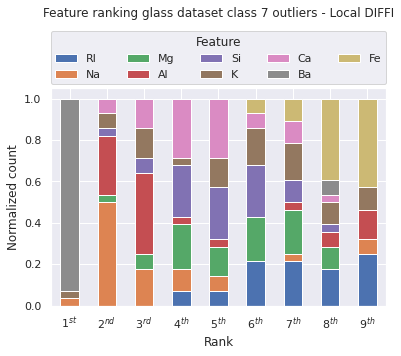

In [8]:
diffi_te, ord_idx_diffi_te = DIFFI(iforest).explain(X_test)
plot_ranking_glass(ord_idx_diffi_te, title = 'Feature ranking glass dataset class 7 outliers - Local DIFFI')
#print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))

#### SHAP

Average computational time SHAP: 0.097


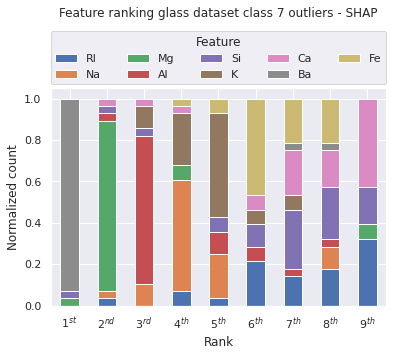

In [9]:
shap_te, ord_idx_shap_te, exec_time_shap_te = local_shap_batch(iforest, X_test[np.where(y_te_pred == 1)])
plot_ranking_glass(ord_idx_shap_te, title = 'Feature ranking glass dataset class 7 outliers - SHAP')
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_te),3)))

## Synthetic dataset
We consider data points represented by a 6-dimensional feature vector. Features $f_1$ and $f_2$ are the coordinates of the points on the 2-D plane, features $f_3$, $f_4$, $f_5$, $f_6$ are white noise samples. Inliers are concentrated near the origin, while outliers are far away from the origin.

### Load data

In [12]:
X_tr, y_tr, X_xaxis, X_yaxis, X_bisec = load_syntethic_dataset()

### Train the Isolation Forest

In [13]:
iforest = IsolationForest(n_estimators=100, 
                          max_samples=256, 
                          contamination='auto', 
                          random_state=0, 
                          bootstrap=False)
iforest.fit(X_tr)
y_tr_pred = np.array(iforest.decision_function(X_tr) < 0).astype('int')
f1 = f1_score(y_tr, y_tr_pred)
print('\nF1 score (on training data): {}'.format(round(f1, 3)))


F1 score (on training data): 0.716


### Get predictions and interpretations for test outliers
We consider as test outliers the points displayed in the figure below (projected on the subspace of the relevant features, i.e. $f_1$ and $f_2$). We have:

- outliers on the x-axis (blue points)
- outliers on the y-axis (orange points)
- outliers on the bisector (green points).

We compare feature importance scores provided by SHAP with those obtained with Local-DIFFI.

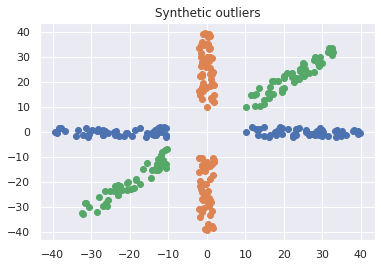

In [17]:
fig, ax = plt.subplots()
ax.scatter(X_xaxis[:,0], X_xaxis[:,1], cmap='Blues')
ax.scatter(X_yaxis[:,0], X_yaxis[:,1], cmap='Greens')
ax.scatter(X_bisec[:,0], X_bisec[:,1], cmap='Oranges')
ax.set_title('Synthetic outliers');

#### Predictions - Outliers on the x-axis

In [18]:
y_xaxis_pred = np.array(iforest.decision_function(X_xaxis) < 0).astype('int')
print('Detected anomalies: {} out of {}'.format(int(sum(y_xaxis_pred)), len(y_xaxis_pred)))

Detected anomalies: 48 out of 100


#### Local-DIFFI - Outliers on the x-axis

In [19]:
diffi_xaxis, ord_idx_diffi_xaxis = DIFFI(iforest).explain(X_xaxis[np.where(y_xaxis_pred == 1)])
plot_ranking_syn(ord_idx_diffi_xaxis, 'Feature ranking syn dataset, ' + r'$f_1$'+ ' outliers - Local DIFFI')
#print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_xaxis),3)))

NameError: name 'plot_ranking_syn' is not defined

#### SHAP - Outliers on the x-axis

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.

Average computational time SHAP: 0.705


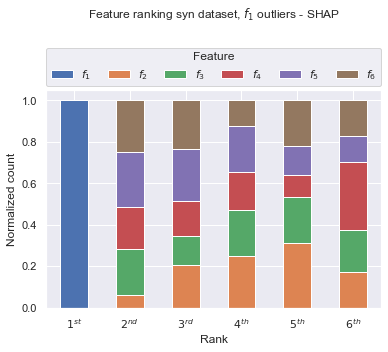

In [12]:
shap_xaxis, ord_idx_shap_xaxis, exec_time_shap_xaxis = local_shap_batch(iforest, X_xaxis[np.where(y_xaxis_pred == 1)])
plot_ranking_syn(ord_idx_shap_xaxis, 'Feature ranking syn dataset, ' + r'$f_1$'+ ' outliers - SHAP')
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_xaxis),3)))

#### Predictions - Outliers on the y-axis

In [13]:
y_yaxis_pred = np.array(iforest.decision_function(X_yaxis) < 0).astype('int')
print('Detected anomalies: {} out of {}'.format(int(sum(y_yaxis_pred)), len(y_yaxis_pred)))

Detected anomalies: 34 out of 100


#### Local-DIFFI - Outliers on the y-axis

Average computational time Local-DIFFI: 0.068


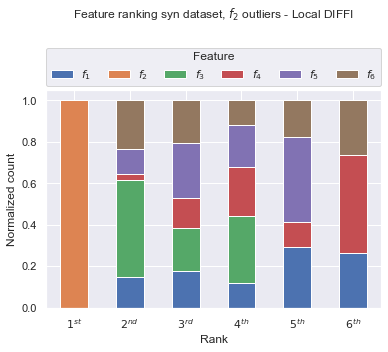

In [14]:
diffi_yaxis, ord_idx_diffi_yaxis, exec_time_diffi_yaxis = local_diffi_batch(iforest, X_yaxis[np.where(y_yaxis_pred == 1)])
plot_ranking_syn(ord_idx_diffi_yaxis, 'Feature ranking syn dataset, ' + r'$f_2$'+ ' outliers - Local DIFFI')
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_yaxis),3)))

#### SHAP - Outliers on the y-axis

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.

Average computational time SHAP: 0.708


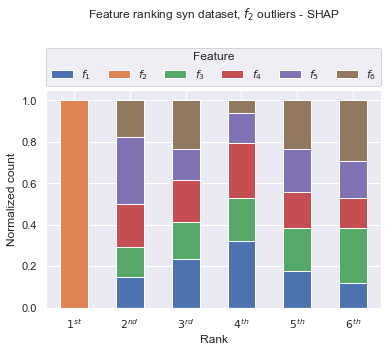

In [15]:
shap_yaxis, ord_idx_shap_yaxis, exec_time_shap_yaxis = local_shap_batch(iforest, X_yaxis[np.where(y_yaxis_pred == 1)])
plot_ranking_syn(ord_idx_shap_yaxis, 'Feature ranking syn dataset, ' + r'$f_2$'+ ' outliers - SHAP')
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_yaxis),3)))

#### Predictions - Outliers on the bisector

In [16]:
y_bisec_pred = np.array(iforest.decision_function(X_bisec) < 0).astype('int')
print('Detected anomalies: {} out of {}'.format(int(sum(y_bisec_pred)), len(y_bisec_pred)))

Detected anomalies: 94 out of 100


#### Local-DIFFI - Outliers on the bisector

Average computational time Local-DIFFI: 0.068


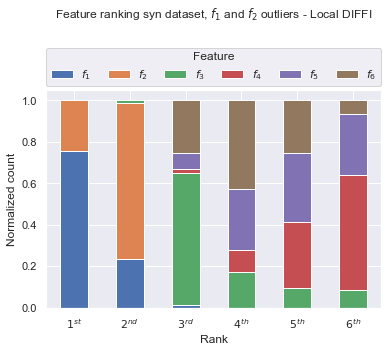

In [17]:
# Local-DIFFI
diffi_bisec, ord_idx_diffi_bisec, exec_time_diffi_bisec = local_diffi_batch(iforest, X_bisec[np.where(y_bisec_pred == 1)])
plot_ranking_syn(ord_idx_diffi_bisec, 'Feature ranking syn dataset, ' + r'$f_1$'+ ' and ' +r'$f_2$'+ ' outliers - Local DIFFI')
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_bisec),3)))

#### SHAP - Outliers on the bisector

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Average computational time SHAP: 0.667


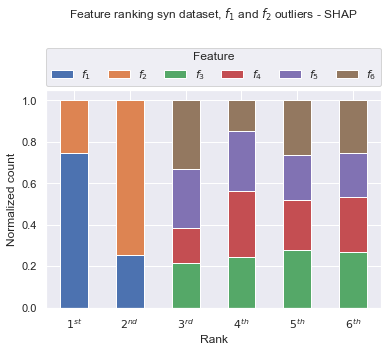

In [18]:
shap_bisec, ord_idx_shap_bisec, exec_time_shap_bisec = local_shap_batch(iforest, X_bisec[np.where(y_bisec_pred == 1)])
plot_ranking_syn(ord_idx_shap_bisec, 'Feature ranking syn dataset, ' + r'$f_1$'+ ' and ' +r'$f_2$'+ ' outliers - SHAP')
print('Average computational time SHAP: {}'.format(round(np.mean(exec_time_shap_bisec),3)))